# <center>Детектирование медицинских масок
## <center>Подготовка датасета
Датасет был скачан с [<i><b>Kaggle</b></i>](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

In [1]:
import os
import warnings
import pickle
import time
import pandas as pd
from multiprocessing import cpu_count
# Personal Dataset class
from data_classes.custom_dataset import CustomImageDataset
# DL/ML
import torch
import pytorch_lightning as pl
import albumentations as A
import cv2
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.detection import IntersectionOverUnion, MeanAveragePrecision
from supervision.metrics.detection import ConfusionMatrix
# Visualization
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Plotly configuration
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
# Project constants
torch.set_float32_matmul_precision('high')
# warnings.filterwarnings('ignore')
DATA_PATH_IMAGES = '../data/images'
DATA_PATH_ANNOTATIONS = '../data/annotations'
BATCH_SIZE = 4
RANDOM_STATE = 42
NN_INPUT = (384, 384)
# Check if GPU available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU_THREADS = cpu_count()
print(f'Available accelerator: {DEVICE}\nTotal CPU threads: {CPU_THREADS}\n')
if DEVICE == 'cuda':
    !nvidia-smi

Available accelerator: cuda
Total CPU threads: 20

Tue Feb  6 01:35:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             29W /  370W |    6096MiB /  12288MiB |     21%      Default |
|                                         |                        |                  N/A

Создадим объекты датасета для обучающей, валидационной и тестовой выборок с помощью [<b>класса датасета</b>](data_classes/custom_dataset.py). Все лейблы будут разделены **стратифицированно**

К обучающей выборке добавим **аугментации**

In [2]:
# ImageNet mean and std
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
normalize = A.Normalize(mean, std)
# Unnormalizer for visualisation
inv_normalize = v2.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)
bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
# Train augmentations
train_transform = A.Compose([
    A.Resize(*NN_INPUT),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2
    ),
    A.RandomGamma(),
    normalize,
    A.ToFloat()
], bbox_params=bbox_params)
# Val transforms
val_transform = A.Compose([
    A.Resize(*NN_INPUT),
    normalize,
    A.ToFloat()
], bbox_params=bbox_params)
# Lambda func to convert image from normalized torch.float32 to unnormalized torch.uint8 
restore_original_img = lambda img: v2.ToDtype(torch.uint8, scale=True)(inv_normalize(img).permute(1, 2, 0).cpu())
# Initialize datasets
train_dataset = CustomImageDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='train',
    transform=train_transform,
    device=DEVICE
)
val_dataset = CustomImageDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='val',
    transform=val_transform,
    device=DEVICE
)
test_dataset = CustomImageDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='test',
    transform=val_transform,
    device=DEVICE
)
# Print results
print(
    f'Количество обучающих примеров: {len(train_dataset)}',
    f'Количество валидационных примеров: {len(val_dataset)}',
    f'Количество тестовых примеров: {len(test_dataset)}', sep='\n'
)

Количество обучающих примеров: 742
Количество валидационных примеров: 347
Количество тестовых примеров: 350


В каждом объекте датасета есть атрибут `df`, который хранит в себе `pandas.DataFrame` из названий изображений, лейблов, ширине, высоте и координатах *bounding box*. Объединим всё в один датафрейм, чтобы визуализировать распределение классов

In [3]:
data = train_dataset.full_df
data.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,maksssksksss603.png,with_mask,400,278,49.0,11.0,55.0,17.0
1,maksssksksss603.png,with_mask,400,278,32.0,52.0,40.0,60.0
2,maksssksksss603.png,without_mask,400,278,52.0,76.0,61.0,86.0
3,maksssksksss603.png,with_mask,400,278,47.0,98.0,58.0,109.0
4,maksssksksss603.png,with_mask,400,278,68.0,100.0,75.0,111.0


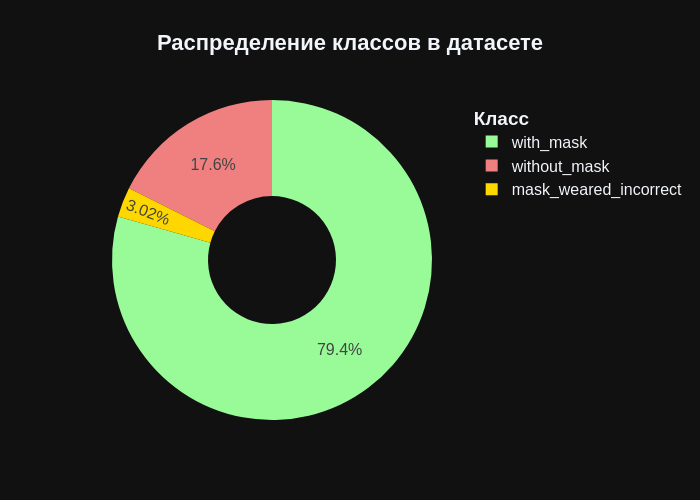

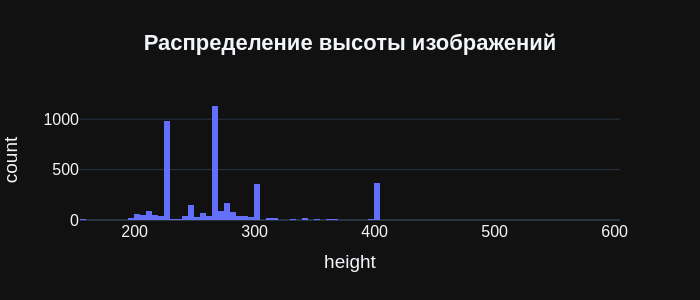

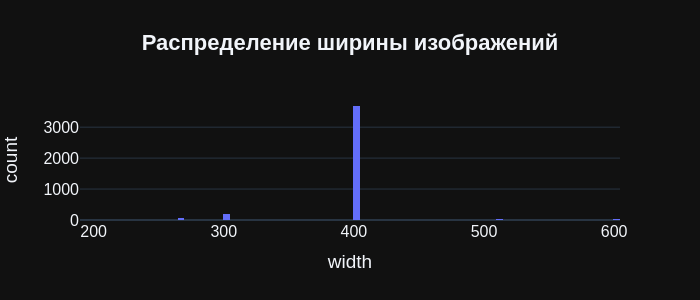

In [4]:
px.pie(
    data_frame=data, 
    names='label', 
    hole=0.4,
    title='<b>Распределение классов в датасете</b>',
    color_discrete_sequence=['PaleGreen', 'LightCoral', 'Gold'],
    height=500,
    width=700
).update_layout(
    legend_title='<b>Класс</b>',
    font=dict(size=16),
    title_x=0.5
).show()

px.histogram(
    data, 
    x='height',
    title='<b>Распределение высоты изображений</b>',
    height=300,
    width=700
).update_layout(
    font=dict(size=16),
    title_x=0.5
).show()

px.histogram(
    data, 
    x='width',
    title='<b>Распределение ширины изображений</b>',
    height=300,
    width=700
).update_layout(
    font=dict(size=16),
    title_x=0.5
).show()

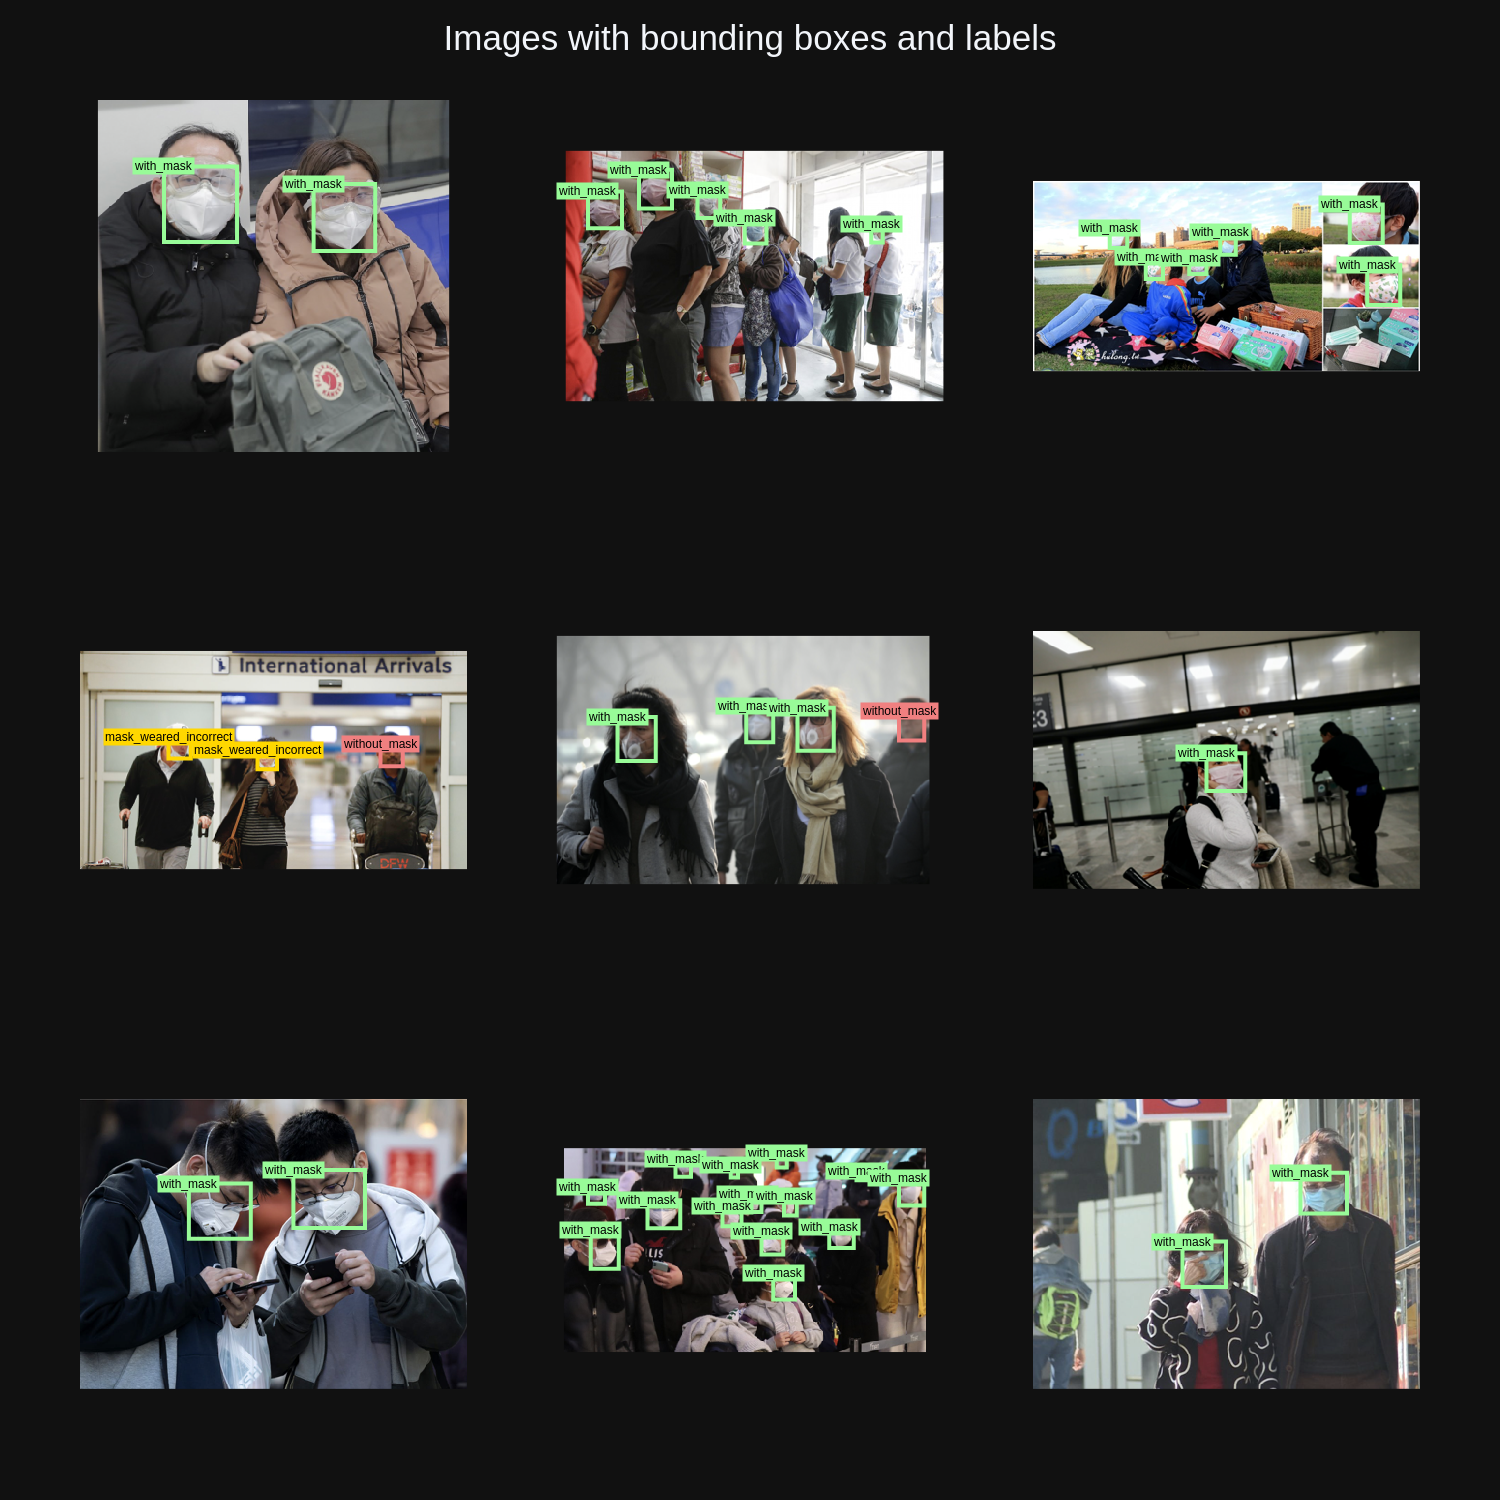

In [5]:
def visualize_dataset_batch(dataset:CustomImageDataset, rows=3, cols=3):
    items_df = dataset.full_df
    batch_name_sample = pd.Series(items_df['name'].unique()).sample(rows*cols)
    batch_sample = items_df[items_df['name'].isin(batch_name_sample)]
    # Grid for plots
    grid = make_subplots(
        rows=rows,
        cols=cols,
    )
    iterators = [
        batch_name_sample.values, # total images to display
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for img_name, row, col in zip(*iterators):
        # Read image, convert BGR -> RGB
        image = cv2.imread(os.path.join(DATA_PATH_IMAGES, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Add image to grid
        fig = px.imshow(image)
        grid.add_trace(fig.data[0], row=row, col=col)
        for _, batch_row in batch_sample[batch_sample['name'] == img_name].reset_index(drop=True).iterrows():
            label, xmin, ymin, xmax, ymax = batch_row[['label', 'xmin', 'ymin', 'xmax', 'ymax']].values
            match label:
                case 'with_mask':
                    color = 'PaleGreen'
                case 'without_mask':
                    color = 'LightCoral'
                case 'mask_weared_incorrect':
                    color = 'Gold'
            # Add bbox for image
            grid.add_trace(
                go.Scatter(
                    x=[xmin, xmin, xmax, xmax, xmin],
                    y=[ymin, ymax, ymax, ymin, ymin],
                    mode='lines+text',
                    line=dict(width=4, color=color),
                ), row=row, col=col
            )
            # Add label for image
            grid.add_annotation(
                x=xmin,
                y=ymin,
                bgcolor=color,
                text=label,
                font=dict(color='black', size=12),
                align='left',
                showarrow=False,
                row=row,
                col=col
            )
    # Axes and layout configuration
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1500,
        width=1500,
        title='Images with bounding boxes and labels',
        title_x=0.5,
        font_size=25,
        showlegend=False
    ).show()

visualize_dataset_batch(train_dataset)

## <center>Deep Learning

In [6]:
class RetinaNet(pl.LightningModule):
    def __init__(
        self, 
        *args, 
        num_classes=3,
        lr=1e-4, 
        gamma=0.8,
        iou_threshold=0.5,
        box_format='xyxy',
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.num_classes = num_classes
        self.lr = lr
        self.gamma = gamma
        self.box_format = box_format
        self.iou_threshold = iou_threshold
        self.net = retinanet_resnet50_fpn_v2(
            weights_backbone='DEFAULT',
            num_classes=self.num_classes
        )
        self.IoU = IntersectionOverUnion(
            box_format=self.box_format,
            iou_threshold=self.iou_threshold
        )
        self.mAP = MeanAveragePrecision(
            box_format=self.box_format, 
            iou_type='bbox', 
            iou_thresholds=[self.iou_threshold],
            extended_summary=True,
            average='macro'
        )
        self.mAP.warn_on_many_detections = False
        
    def forward(self, inputs, target=None):
        if target is not None:
            return self.net.train()(inputs, target)
        else:
            with torch.no_grad():
                return self.net.eval()(inputs)
    
    def training_step(self, batch, batch_idx):
        inputs, target = batch
        loss = sum(self.forward(inputs, target).values())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(params=self.net.parameters(), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=self.gamma)
        return [optimizer], [lr_scheduler]
    
    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        outputs = self.forward(inputs)
        iou = self.IoU(outputs, target)['iou']
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            extended_map_output = self.mAP(outputs, target)
        map_ = extended_map_output['map']
        precision = extended_map_output['precision']
        recall = extended_map_output['recall']
        precision = precision[precision >= 0].mean()
        recall = recall[recall >= 0].mean() 
        f1_score = 2*precision*recall / (precision+recall)
        self.log('IoU', iou, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('mAP', map_, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('Precision', precision, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('Recall', recall, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('F1-score', f1_score, prog_bar=True, on_epoch=True, logger=True, on_step=False)

    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=CPU_THREADS
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CPU_THREADS
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False, 
    collate_fn=collate_fn,
    # num_workers=CPU_THREADS
)

In [8]:
retinanet = RetinaNet()

In [9]:
logger = CSVLogger(save_dir='logs', name='retina_logs', flush_logs_every_n_steps=len(train_loader))
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(
    dirpath='../models/',
    save_weights_only=True,
    mode='max',
    monitor='mAP'
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator=DEVICE,
    logger=logger,
    callbacks=[
        lr_monitor, 
        checkpoint_callback
    ],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(retinanet, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: UserWarning:

Checkpoint directory /home/deep_learning/Detection of medical masks/models exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                  | Params
-----------------------------------------------
0 | net  | RetinaNet             | 36.4 M
1 | IoU  | IntersectionOverUnion | 0     
2 | mAP  | MeanAveragePrecision  | 0     
-----------------------------------------------
36.1 M    Trainable params
225 K     Non-trainable params
36.4 M    Total params
145.493   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [93]:
trainer.validate(retinanet, val_loader, ckpt_path='../models/epoch=17-step=3348.ckpt')

Restoring states from the checkpoint path at ../models/epoch=17-step=3348.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/epoch=17-step=3348.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            IoU            │    0.8219251036643982     │
│         Precision         │     0.798873973277843     │
│          Recall           │     0.806991677338628     │
│            mAP            │    0.9623664617538452     │
└───────────────────────────┴───────────────────────────┘

[{'IoU': 0.8219251036643982,
  'mAP': 0.9623664617538452,
  'Precision': 0.798873973277843,
  'Recall': 0.806991677338628}]

In [94]:
trainer.test(retinanet, test_loader, ckpt_path='../models/epoch=17-step=3348.ckpt')

Restoring states from the checkpoint path at ../models/epoch=17-step=3348.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/epoch=17-step=3348.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

In [9]:
final_model = RetinaNet.load_from_checkpoint('../models/epoch=17-step=3348.ckpt')

In [39]:
cm = ConfusionMatrix.from_tensors

In [11]:
iter_loader = iter(test_loader)

In [12]:
img_test, target_test = next(iter_loader)

In [13]:
outputs = final_model(img_test)

In [68]:
targets = torch.cat([target_test[1]['boxes'], target_test[1]['labels'].reshape(-1, 1)], dim=1).cpu().numpy()
predictions = torch.cat([outputs[1]['boxes'], outputs[1]['labels'].reshape(-1, 1), outputs[1]['scores'].reshape(-1, 1)], dim=1).cpu().numpy()

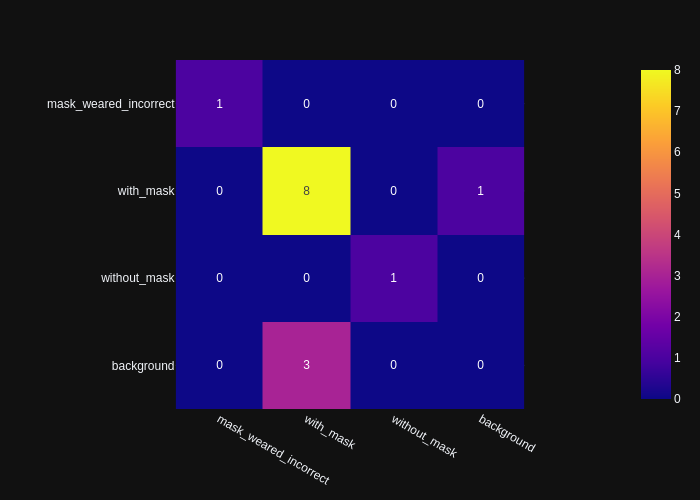

In [69]:
conf_matrix = cm(predictions=[predictions], targets=[targets], classes=train_dataset.label_encoder.classes_)
px.imshow(conf_matrix.matrix, x=list(conf_matrix.classes)+['background'], y=list(conf_matrix.classes)+['background'], text_auto=True)

In [108]:
# mcm(outputs[0]['labels'][:len(target_test[0]['labels'])], target_test[0]['labels']) + \
# mcm(outputs[0]['labels'][:len(target_test[0]['labels'])], target_test[0]['labels'])

tensor([[ 0,  0,  0],
        [ 0, 18,  0],
        [ 0,  0,  0]], device='cuda:0')

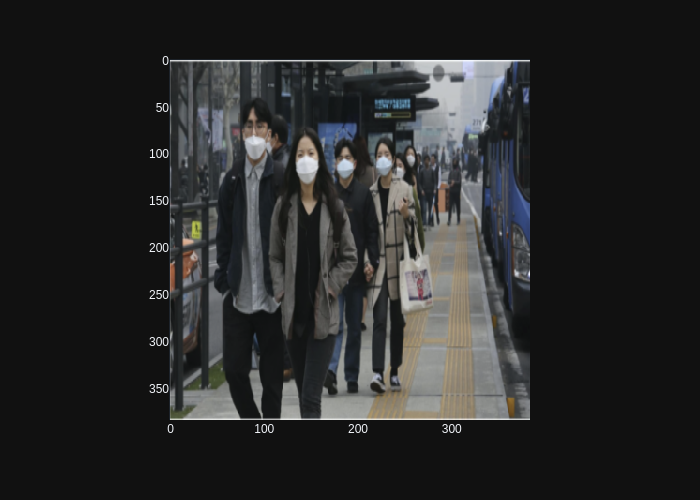

In [67]:
px.imshow(restore_original_img(img_test[0]))